In [1]:
%matplotlib widget

#import the modules needed
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import exoplanet as xo
from glob import glob 
from exoplanet.orbits import get_true_anomaly
import corner
import collections

import pymc3 as pm
import pymc3_ext as pmx
import pymc3.stats as pstats
import theano.tensor as tt

from matplotlib import rc
import radvel
import astropy.units as u
import astropy.constants as co

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/Users/neisner/opt/anaconda3/envs/exoplanet/lib/python3.9/site-packages/radvel/gp.py:32: ImportWarning: celerite not installed. GP kernals using celerite will not work. Try installing celerite using 'pip install celerite'
  warnings.warn("celerite not installed. GP kernals using celerite will not work. \


In [2]:
print (np.__version__)
#! pip install numpy==1.21.6

1.21.6


In [3]:
# change these numbers - these are examples for TIC 470710327

period = 1.104686  
t0 = 1766.270

def get_etv_data(files, period, t0, period_remove = None, t0_remove = None, num_eclipses = None):

    '''
    files: list of file names to be read in
    period: period of the binary
    t0: time of eclipses
    period_remove: period of the binary to be removed (only if not None)
    t0_remove: time of eclipses to be removed(only if not None)
    num_eclipses: number of eclipses to be removed (only if not None)
    
    '''
    
    x_etv =  []
    y_etv =  []
    yerr_etv  = []
    yerr_etv2 = []
    
    for file in files:
        in_df = pd.read_csv(file) # open CSV file

        in_df['midpoint'] = in_df['epoch'] 
        in_df['shift_mins'] = in_df['t0']*period*24*60
        in_df['std_mins'] = in_df['stdv']*period*24*60
        
        x_etv.append(np.array(list(in_df['epoch'])))
        y_etv.append(np.array(list(in_df['shift_mins'])))
        yerr_etv.append(np.array(list(in_df['std_mins'])))
      
    
    x_etv = np.hstack(x_etv)
    y_etv = np.hstack(y_etv)
    yerr_etv = np.hstack(yerr_etv)

    
    if period_remove is not None:
    
        for i in range(0,num_eclipses):
            
            time = t0_remove + (i*period_remove)
            
            mask = (x_etv > time - 0.15) & (x_etv < time + 0.15) # the size of the window to remove data is hard coded for now
            
            x_etv = x_etv[~mask]
            y_etv = y_etv[~mask]
            yerr_etv = yerr_etv[~mask]
            
    return x_etv, y_etv, yerr_etv
    
    
def get_rv_data(file):
    
    '''
    Function to get the RV data 
    '''

    data_rv = pd.read_csv(file, delimiter = ' ', names = ['time', 'rv', 'snr', 'err'])

    data_rv['time_tjd'] = data_rv['time'] - 2457000.0 # this assumes that the time is in JD  - needs to be converted to TESS JD

    x_rv = np.array(data_rv['time_tjd'].tolist())
    y_rv = np.array(data_rv['rv'].tolist())
    yerr_rv = np.array(data_rv['err'].tolist())

    return x_rv, y_rv, yerr_rv


In [4]:
# this is where the files are on my computer - CHANGE THESE PATHS

period_remove = 4.092
t0_remove = 1765.17
num_eclipses = 55

# get the ETV data
etv_files = sorted(glob('/Users/neisner/Documents/projects/fluffy/reanalysed/onedaysignal/mcmc_etvs_*csv'))
x_etv, y_etv, yerr_etv = get_etv_data(etv_files, period, t0, period_remove = period_remove, t0_remove = t0_remove, num_eclipses = num_eclipses)
x_etv, y_etv, yerr_etv = zip(*sorted(zip(x_etv,y_etv,yerr_etv)))

# get the RV data
#t, rv, rv_err = get_rv_data('/Users/neisner/Documents/projects/fluffy/HERMES_extracted/mean_helium_rvs_snr.txt')
rv_dat = pd.read_csv('/Users/neisner/Documents/projects/fluffy/HERMES_extracted/mean_helium_rvs_snr.txt', delimiter = ' ', names = ['t', 'rv', 'snr', 'err'])

rv_error = ((rv_dat.snr - np.max(rv_dat.snr))/(np.min(rv_dat.snr) - np.max(rv_dat.snr))) * (7) + 2

x = rv_dat.t
y = np.array(rv_dat.rv) + 40 # + np.median(rv_dat.rv) # make sure the data is centred around 0 
yerr = np.array(rv_error)

x_etv = np.array(x_etv) 
y_etv = np.array(y_etv)
yerr_etv = np.array(yerr_etv) * 10

err_mask = (yerr_etv <2) 

x_etv = x_etv[err_mask]
y_etv = y_etv[err_mask]
yerr_etv = yerr_etv[err_mask] 


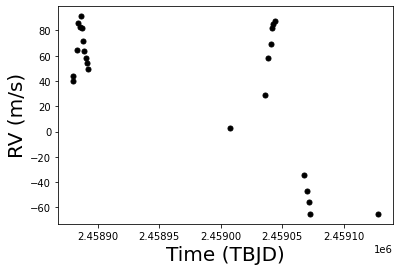

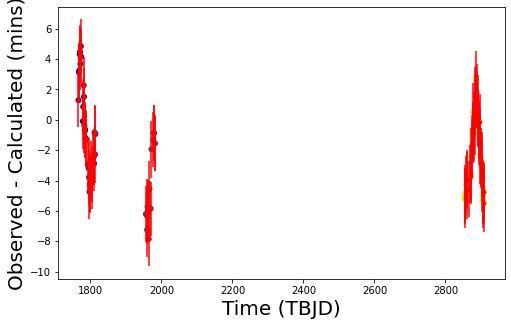

In [5]:
%matplotlib inline 

# plot the RV data to make sure that it looks sensible  
# adjust the normalization if necessary
fig, ax =  plt.subplots()
plt.scatter(x,y, c = 'k', label = 'RV')
plt.xlabel("Time (TBJD)", fontsize = 20)
plt.ylabel("RV (m/s)", fontsize = 20)
plt.show()

# - - - - - - 
# plot the ETV data to make sure that it looks sensible  

fig, ax = plt.subplots(figsize=(8, 5))

plt.scatter(x_etv, y_etv, c = x_etv)
plt.errorbar(x_etv, y_etv, yerr = yerr_etv, fmt = '.r')
plt.xlabel("Time (TBJD)", fontsize = 20)
plt.ylabel("Observed - Calculated (mins)", fontsize = 20)
plt.show()




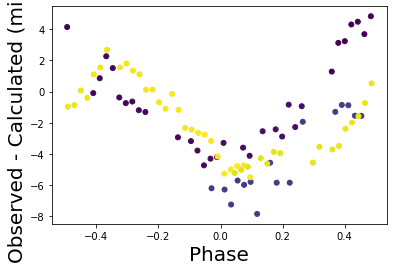

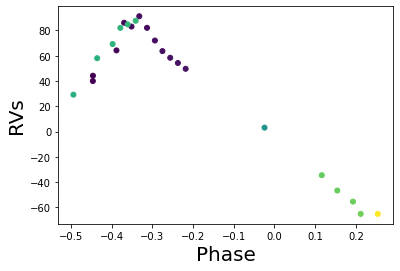

In [6]:
# try some phase folds of the ETV/RV data to het a good prior of the period pf the signa; 

# IN this case
period_tertiary = 52.6
t0_tertiary = 1800

phase = np.array([-0.5+( ( t - t0_tertiary-0.5* period_tertiary) % period_tertiary) / period_tertiary for t in x_etv])  

fig, ax = plt.subplots()
plt.scatter(phase, y_etv, c = x_etv)
plt.xlabel("Phase", fontsize = 20)
plt.ylabel("Observed - Calculated (mins)", fontsize = 20)
plt.show()


phase = np.array([-0.5+( ( t - t0_tertiary-0.5*period_tertiary) % period_tertiary) / period_tertiary for t in x])  

fig, ax = plt.subplots()
plt.scatter(phase, y, c = x)
plt.xlabel("Phase", fontsize = 20)
plt.ylabel("RVs", fontsize = 20)
plt.show()



In [7]:
# Compute a reference time that will be used to normalize the trends model
x_ref = 0.5 * (np.nanmin(x) + np.nanmax(x))

# Also make a fine grid that spans the observation window for plotting purposes
t = np.linspace(np.nanmin(x) - 5, np.nanmax(x) + 5, 1000)


In [8]:
# define the priors for the RV model

# this is the period of the 
periods = [52.6]
period_errs = [2]

t0s = [1878.738] 
t0_errs = [10]

Ks = [81]  # estimate the amplitude of the RV signal 
print(Ks, "m/s")

[81] m/s


In [9]:
def timetrans_to_timeperi(tc, per, ecc, omega):
    ''''
    Function to convert the time of transit to the time of periastron.
    '''
    f = np.pi/2 - omega
    ee = 2 * np.arctan(np.tan(f/2) * np.sqrt((1-ecc)/(1+ecc)))  # eccentric anomaly
    tp = tc - per/(2*np.pi) * (ee - ecc*np.sin(ee))             # time of periastron
    
    return tp
    

In [10]:
# let's define a more sensible naming system 

# 12 refers to the binary (stars 1 and 2) e.g. P12 is the period of the binary
# 3 refers to the tertiary star (star 3) e.g. P3 is the period of the tertiary

P12 = period
t012 =  t0
M3 = 15 # we the mass of the tertiary from spectroscopic data

with pm.Model() as model:

    # Gaussian priors based on transit data (from Petigura et al.)
    t03 = pm.Normal("t0", mu=t0s[0], sd=t0_errs[0])
 
    P3 = pm.Bound(pm.Normal, lower=1)("P",mu=52.6,sd=5,testval=52.6)
    
    # Wide log-normal prior for semi-amplitude
    logK = pm.Bound(pm.Normal, lower=0)("logK", mu=np.log(72.168), sd=10, testval=np.log(72.168))
    
    # Eccentricity & argument of periasteron
    ecc3 = pm.Bound(pm.Normal, lower=0.2, upper=0.40)('ecc3', mu = 0.3, sd =0.2, testval=0.28)

    omega3 = pm.Uniform("omega", lower = 0, upper = 2*np.pi, testval=5.1609386)
    
    tp3 = pm.Deterministic("tp3", timetrans_to_timeperi(t03, P3, ecc3, omega3))
    
    # Priors
    c0 = pm.Normal("c0",mu=0,sd=5,testval=0)   
    c1 = pm.Normal("c1",mu=0,sd=0.5,testval=0)
    c2 = pm.Normal("c2",mu=0,sd=0.001,testval=-0.0001)

    i_mutual = pm.Uniform("i_mutual", lower = 0, upper = np.pi/2,  testval= 0.5)
    
    g2 = pm.Uniform("g2", lower =  0, upper = 2 * np.pi, testval= 6.2666047)

    asini_ab = pm.Uniform("asini_ab", lower=60, upper=130, testval=91.2)
    
    asini_c = pm.Deterministic("asini_c", (1.9758 * 1e-2) * np.sqrt(1-(ecc3**2)) * np.exp(logK) * P3)
    
    q_ = pm.Deterministic("q_", asini_ab / asini_c)  
    mass_ratio = pm.Deterministic("mass_ratio", 1/((1/q_) + 1))
    
    
    # Jitter & a quadratic RV trend
    logs = pm.Normal("logs", mu=np.log(np.median(yerr)), sd=5.0)
    trend = pm.Normal("trend", mu=0, sd=0.00000001 ** -np.arange(3)[::-1], shape=3)

    # Then we define the orbit
    orbit = xo.orbits.KeplerianOrbit(period=P3, t_periastron=t03, ecc=ecc3, omega=omega3)
    
    # And a function for computing the full RV model
    def get_rv_model(t, name=""):
        # First the RVs induced by the planets
        vrad = orbit.get_radial_velocity(t, K=tt.exp(logK))
        pm.Deterministic("vrad" + name, vrad)

        # Define the background model
        A = np.vander(t - x_ref, 3)
        bkg = pm.Deterministic("bkg" + name, tt.dot(A, trend))

        # Sum over planets and add the background to get the full model
        return pm.Deterministic("rv_model" + name, vrad), bkg
    
    # Define the RVs at the observed times
    rv_model, rv_bkg_model = get_rv_model(x)
    
    # Also define the model on a fine grid as computed above (for plotting)
    rv_model_pred, rv_bkg_model_pred = get_rv_model(t, name="_pred")

    # Finally add in the observation model. This next line adds a new contribution
    # to the log probability of the PyMC3 model
    err = tt.sqrt(yerr ** 2 + tt.exp(2 * logs))
    pm.Normal("obs", mu=rv_model, sd=err, observed=y)
    
    
    def etv_dyn(t, P3, tp, ecc3, i_mutual, mass_ratio, g2):
        '''
        Dynamical term. 
        '''
        M = tt.zeros_like(tt.constant(t)) + 2.0 * np.pi * (tt.constant(t)) / P3
        true_anom3 = get_true_anomaly(M, ecc3 + tt.zeros_like(M))
        
        MM = ((3. * ecc3 * np.sin(true_anom3)) - ( (3./4.) * (ecc3**2) * (np.sin(2*true_anom3))) + ((1/3.) * (ecc3**3) * (np.sin(3*true_anom3))))
        SS = np.sin((2* true_anom3) + (2*g2)) + (ecc3 * (np.sin(true_anom3 + (2*g2)) + (1/3. * np.sin((3.*true_anom3) + (2 * g2)))))
        
        delta_dyn = (((3. / (4 * np.pi)) * (mass_ratio) * (((P12)**2)/(P3)) * (1. - (ecc3**2))**(-3./2)) *
                    ((((2./3) - (np.sin(i_mutual)**2)) * MM) + (0.5*(np.sin(i_mutual)**2) * SS))) * 1440
        
        return delta_dyn
    
    
    def etv_ltte(t, c0, c1, c2, t012, P12, P3, tp, ecc3, asini, omega3):
        '''
        Light Travel Time Effect (LTTE) term. 
        '''
        E = abs(np.round((t - t012) / P12, 1))

        M = tt.zeros_like(tt.constant(t)) + 2.0 * np.pi * (tt.constant(t)) / P3
        true_anom3 = get_true_anomaly(M, ecc3 + tt.zeros_like(M))
    
        
        # convert from Rsun to m
        asini_m  = asini * 696000000 
        c = 299792458 # m/s
        
        delta_LTTE = - (((asini_m)/c) * (((1 - (ecc3**2.)) * np.sin(true_anom3 + omega3)) / (1 + ecc3*np.cos(true_anom3)))) / 60 # convert from seconds to minutes

        return c0 + (c1*E) + (c2*E**2) + (delta_LTTE)
        
        
    def etv_model(t, c0, c1, c2, t012, P12, P3, tp, ecc3, omega3, i_mutual, mass_ratio, asini, g2, name=""):
        
        delta_dyn = pm.Deterministic('delta_dyn' + name, etv_dyn(t, P3, tp, ecc3, i_mutual, mass_ratio, g2))
        delta_LTTE = pm.Deterministic('delta_ltte' + name, etv_ltte(t, c0, c1, c2, t012, P12, P3, tp, ecc3, asini, omega3))

        # the LTTE and dynamical effects are added together to get the final model
        return pm.Deterministic("etv_model" + name, delta_dyn + delta_LTTE )
    

    # Expected value of outcome
    x_etv_array = np.arange(np.nanmin(x_etv) - 10, np.nanmax(x_etv) + 10, P12/2)
    
    etvmodel = etv_model(x_etv, c0, c1, c2, t012, P12, P3, tp3, ecc3, omega3, i_mutual, mass_ratio, asini_ab, g2)
    etvmodel_pred = etv_model(x_etv_array, c0, c1, c2, t012, P12, P3, tp3, ecc3, omega3, i_mutual, mass_ratio, asini_ab, g2, name = '_pred')
    
    # Condition on the observations
    pm.Normal("obs_etv", mu=etvmodel, sd=yerr_etv, observed=y_etv)


In [11]:
# optimize the model 

with model:
    map_params = pmx.optimize()
    

optimizing logp for variables: [trend, logs, asini_ab, g2, i_mutual, c2, c1, c0, omega, ecc3, logK, P, t0]


message: Desired error not necessarily achieved due to precision loss.
logp: -64536.03960221625 -> -329.29738467995844


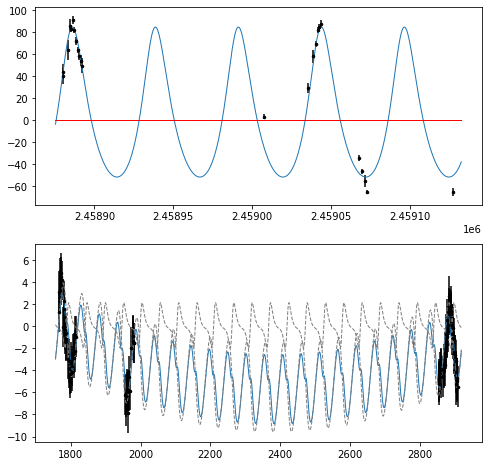

In [12]:
%matplotlib inline

# plot initial fit 

fig, ax = plt.subplots(2, 1, figsize=(8, 8))

ax[0].errorbar(x, y, yerr=yerr, fmt=".k")
ax[0].plot(t, map_params["rv_model_pred"], color="C0", lw=1)
ax[0].plot(t, map_params["bkg_pred"], color="r", lw=1)

ax[1].errorbar(x_etv, y_etv, yerr=yerr_etv, fmt=".k")
ax[1].plot(x_etv_array, map_params["etv_model_pred"], color="C0", lw=1)
ax[1].plot(x_etv_array, map_params["delta_dyn_pred"], ls = '--', color="grey", lw=1)
ax[1].plot(x_etv_array, map_params["delta_ltte_pred"], ls = '--', color="grey", lw=1)


In [13]:
with model:
    map_soln = pmx.optimize(start=model.test_point, vars=[trend])
    map_soln = pmx.optimize(start=map_soln)

optimizing logp for variables: [trend]


message: Optimization terminated successfully.
logp: -64536.03960221625 -> -64536.03960221625
optimizing logp for variables: [trend, logs, asini_ab, g2, i_mutual, c2, c1, c0, omega, ecc3, logK, P, t0]


message: Desired error not necessarily achieved due to precision loss.
logp: -64536.03960221625 -> -329.29738467995844


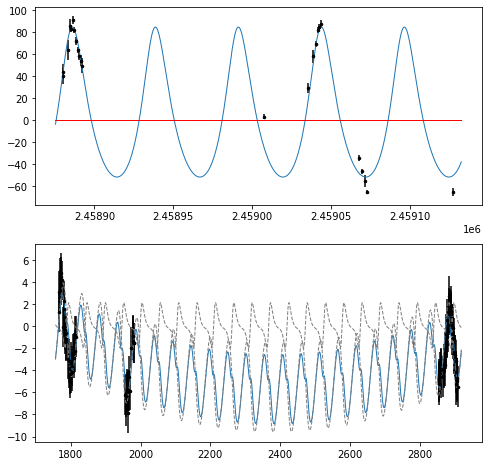

In [14]:
# plot initial fit 
 
fig, ax = plt.subplots(2, 1, figsize=(8, 8))

ax[0].errorbar(x, y, yerr=yerr, fmt=".k")
ax[0].plot(t, map_soln["rv_model_pred"], color="C0", lw=1)
ax[0].plot(t, map_soln["bkg_pred"], color="r", lw=1)

ax[1].errorbar(x_etv, y_etv, yerr=yerr_etv, fmt=".k")
ax[1].plot(x_etv_array, map_soln["etv_model_pred"], color="C0", lw=1)
ax[1].plot(x_etv_array, map_soln["delta_dyn_pred"], ls = '--', color="grey", lw=1)
ax[1].plot(x_etv_array, map_soln["delta_ltte_pred"], ls = '--', color="grey", lw=1)

In [15]:
for RV in model.basic_RVs:
    print(RV.name, RV.logp(model.test_point))

t0 -3.2215236261987186
P_lowerbound__ 1.415145226848744
logK_lowerbound__ -1.767805051943966
ecc3_interval__ -2.3510548888448186
omega_interval__ -1.919303006090253
c0 -2.528376445638773
c1 -0.2257913526447274
c2 5.983816745777465
i_mutual_interval__ -1.527909988817906
g2_interval__ -5.940040948737759
asini_ab_interval__ -1.3981521426540535
logs -2.528376445638773
trend -58.01885783147112
obs -137.77876509880173
obs_etv -64324.232607357124


In [16]:
# run MCMC using NUT sampler
np.random.seed(42)

with model:
    trace = pm.sample(
        tune=6000,
        draws=6000,
        cores=2,
        chains=2,
        target_accept=0.95,
        init="adapt_full")

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [trend, logs, asini_ab, g2, i_mutual, c2, c1, c0, omega, ecc3, logK, P, t0]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 6_000 tune and 6_000 draw iterations (12_000 + 12_000 draws total) took 142 seconds.
The acceptance probability does not match the target. It is 0.7139756461422461, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [17]:
# define a burn-in 

trace2 = trace[5000:]
df = pm.stats.summary(trace2, var_names=["trend", "logs", "omega", "ecc3", "t0", "logK", "P", "c0", "c1", "c2", "i_mutual", "g2", "asini_ab", "asini_c", "q_","mass_ratio"])
varnames=["logs", "omega", "ecc3", "t0", "logK", "P", "c0", "c1", "c2", "i_mutual", "g2", "asini_ab", "mass_ratio", "asini_c", "q_"]

Got error No model on context stack. trying to find log_likelihood in translation.


In [18]:
for var in varnames:
    intvls  = pstats.hdi(trace2[var],1.-0.6827)
    ci_smpl = trace2[var][np.where( ( (trace2[var]>intvls[0]) & (trace2[var]<intvls[1]) ) )[0]]
    
    ci_mdn  = np.nanmedian(trace2[var])
    #print ("{}    :  {}         - {}    + {}".format(var, ci_mdn, ci_mdn - intvls[0],  intvls[1] - ci_mdn))
    print ("{}    =  [{}         , {}   , {}]".format(var, np.round(ci_mdn,5),  np.round(intvls[0],5),  np.round(intvls[1],5)))
    
    

logs    =  [2.23085         , 2.13724   , 2.27679]
omega    =  [6.05645         , 6.0431   , 6.12348]
ecc3    =  [0.24175         , 0.21923   , 0.24326]
t0    =  [1878.55574         , 1874.79631   , 1883.5359]
logK    =  [4.22364         , 4.21632   , 4.24379]
P    =  [52.60017         , 52.60012   , 52.6003]
c0    =  [0.33449         , 0.07848   , 0.39679]
c1    =  [-0.0214         , -0.02247   , -0.01893]
c2    =  [2e-05         , 2e-05   , 2e-05]
i_mutual    =  [0.62847         , 0.51116   , 0.65818]
g2    =  [0.41521         , 0.22332   , 0.4312]
asini_ab    =  [101.5701         , 109.8298   , 127.34685]
mass_ratio    =  [0.59535         , 0.60969   , 0.64614]
asini_c    =  [68.76217         , 67.89199   , 69.8321]
q_    =  [1.47128         , 1.53902   , 1.80245]


In [19]:
for n in range (0,3):
    var = 'trend'

    intvls  = pstats.hdi(trace2[var][:,n],1.-0.6827)
    ci_smpl = trace2[var][:,n][np.where( ( (trace2[var][:,n]>intvls[0]) & (trace2[var][:,n]<intvls[1]) ) )[0]]
    
    ci_mdn  = np.median(trace2[var][:,n])
    
    print ("{}_{}  :  {}         - {}    + {}".format(var, n, ci_mdn, ci_mdn - intvls[0],  intvls[1] - ci_mdn))

trend_0  :  -724600646489557.8         - 3788847495278716.0    + 4374703444855347.0
trend_1  :  1655091.144562154         - 39346779.360790424    + 35159590.894912176
trend_2  :  -0.032490545995226425         - 0.3155685543572159    + 0.46088453660393663


In [20]:
varnames = ["trend", "logs", "omega", "ecc3", "t0", "logK", "P", "c0", "c1", "c2", "mass_ratio", "i_mutual", "g2", "asini_ab"]
units = ["", "", "", "", "", "deg", "", "d", "", "d", "", "", "", "", "deg", "deg", "R$_\odot$", "", "", "", "", "", "", "", "", "", "", "", "", "", "", "", "", "", ""]

count = 0

# this prints the data ready for LATEX publishing 
for i,row in df.iterrows():
    
    varname =  (i)
    varmean =  round(row['mean'], 4)
    upperval = row['hdi_3%']
    lowerval = row['hdi_97%']
    
    err_minus =  round(varmean - lowerval, 5)
    err_plus  =  round(varmean - upperval, 5)
    
    count +=1
    
    print ("\\newcommand {{\{}}}[1][{}]   {{ $ {} _ {{ {} }} ^ {{ {} }}$~#1}}".format(varname, units[count],varmean, err_minus, err_plus))
    
    #\newcommand{\Pb}[1][days]   {$11.6259 _{ - 0.0044 } ^ { + 0.0041 }$~#1} 


\newcommand {\trend[0]}[1][]   { $ -892067759157771.4 _ { -2.005762228467692e+16 } ^ { 1.921912300121233e+16 }$~#1}
\newcommand {\trend[1]}[1][]   { $ 1119624.949 _ { -171217696.888 } ^ { 178707515.944 }$~#1}
\newcommand {\trend[2]}[1][]   { $ -0.029 _ { -1.79 } ^ { 1.831 }$~#1}
\newcommand {\logs}[1][]   { $ 2.238 _ { -0.315 } ^ { 0.338 }$~#1}
\newcommand {\omega}[1][deg]   { $ 6.037 _ { -0.196 } ^ { 0.231 }$~#1}
\newcommand {\ecc3}[1][]   { $ 0.245 _ { -0.049 } ^ { 0.045 }$~#1}
\newcommand {\t0}[1][d]   { $ 1878.682 _ { -19.41 } ^ { 17.07 }$~#1}
\newcommand {\logK}[1][]   { $ 4.224 _ { -0.065 } ^ { 0.061 }$~#1}
\newcommand {\P}[1][d]   { $ 52.6 _ { -0.001 } ^ { 0.0 }$~#1}
\newcommand {\c0}[1][]   { $ 0.34 _ { -0.692 } ^ { 0.776 }$~#1}
\newcommand {\c1}[1][]   { $ -0.021 _ { -0.008 } ^ { 0.009 }$~#1}
\newcommand {\c2}[1][]   { $ 0.0 _ { 0.0 } ^ { 0.0 }$~#1}
\newcommand {\i_mutual}[1][]   { $ 0.644 _ { -0.339 } ^ { 0.359 }$~#1}
\newcommand {\g2}[1][deg]   { $ 1.296 _ { -2.309 } ^ { 1.2

In [21]:
asini_ab = np.median(trace2.asini_ab)
asini_ab_l = 81.15550970883817
asini_ab_u = 95.6558070172263  

ecc3 = np.median(trace2.ecc3)
ecc3_l = 0.2875518331399773
ecc3_u = 0.311152261323395

k3 = np.exp(np.mean(trace2.logK))
k3_l = np.exp(4.248926187710056)
k3_u = np.exp(4.28905535405788)

P3 = np.median(trace2.P)
P3_l = 52.02026728940281
P3_u = 52.05343946633533

asini_c = (1.9758 * 1e-2) * np.sqrt(1-(ecc3**2)) * np.exp(logK) * P3

asini3 = (1.9758 * 1e-2) * np.sqrt(1-(ecc3**2)) * k3 * P3
asini3km = (1.3751 * 1e4) * np.sqrt(1-(ecc3**2))  * k3 * P3

asini3_u = (1.9758 * 1e-2) * np.sqrt(1-(ecc3_u**2)) * k3_u * P3_u
asini3km_u = (1.3751 * 1e4) * np.sqrt(1-(ecc3_u**2))  * k3_u * P3_u

asini3_l = (1.9758 * 1e-2) * np.sqrt(1-(ecc3_l**2)) * k3_l * P3_l
asini3km_l = (1.3751 * 1e4) * np.sqrt(1-(ecc3_l**2))  * k3_l * P3_l

q_ =  asini3 / asini_ab

q_u =  asini3_l /asini_ab_u
q_l = asini3_u /asini_ab_l

mass_ratio = 1/((1/q_) + 1)
mass_ratio_u = 1/((1/q_l) + 1)
mass_ratio_l = 1/((1/q_u) + 1)

print (" asini_c: {} + {} - {}".format(asini3, asini3_u - asini3, asini3 - asini3_l))
print ("q: {} + {} - {}".format(q_, mass_ratio_u - q_,q_ -  mass_ratio_l))
print ("mass ratio: {} + {} - {}".format(mass_ratio, mass_ratio_u - mass_ratio,mass_ratio -  mass_ratio_l))

 asini_c: 68.85201830829867 + 2.399425270277419 - -0.08615241683448005
q: 0.6778768067298302 + -0.21036897954948047 - 0.2590390602295133
mass ratio: 0.40400868765270515 + 0.06349913952764458 - -0.014829058847611765


In [22]:
logs    =  [4.25023         , 4.18892   , 4.31467]
omega    =  [-1.12841         , -1.23798   , -1.08058]
ecc3    =  [0.27379         , 0.25944   , 0.28153]
t0    =  [1879.87634         , 1879.44422   , 1880.36946]
logK    =  [4.28437         , 4.27565   , 4.30344]
P    =  [52.403         , 52.35426   , 52.41858]
c0    =  [1.1419         , 0.72272   , 1.60066]
c1    =  [-0.0018         , -0.00813   , 0.00175]
c2    =  [0.0         , -0.0   , 1e-05]
i_mutual    =  [0.50267         , 0.39796   , 0.64812]
g2    =  [-0.04419         , -1.59454   , 0.27546]
asini_ab    =  [66.19893         , 51.1806   , 60.80868]
mass_ratio    =  [0.47794         , 0.42448   , 0.46813]
asini_c    =  [72.2984         , 71.36364   , 73.26364]
q_    =  [0.91549         , 0.7185   , 0.85953]


In [23]:

def calculate_K_from_RV(ecc,asini,Porb):
    # Calculates semi-amplitude K according to asini
    # asini in Rsun
    # Porb in days
    # Returns K in km/s
    # eq --> K = asini / [(1.9758e-2) * sqrt(1 - ecc^2) * Porb]
    return asini / ( (1.9758e-2) * np.sqrt(1-ecc**2) * Porb )

def calculate_msin3i(ecc,K1,K2,Porb):
    # Calculates msin3i according to RV variations
    # K in km/s
    # Porb in days
    # Returns m1sin3i and m2sin3i in Msun
    # eq --> m_1_sin3i = (1.0361e-7) * (1 - ecc^2)^1.5 * (K1+K2)^2 * K2 * Porb
    # eq --> m_2_sin3i = (1.0361e-7) * (1 - ecc^2)^1.5 * (K1+K2)^2 * K1 * Porb

    m1sin3i = (1.0361e-7) * ((1-ecc**2)**1.5) * ((K1+K2)**2) * K2 * Porb
    m2sin3i = (1.0361e-7) * ((1-ecc**2)**1.5) * ((K1+K2)**2) * K1 * Porb

    return m1sin3i, m2sin3i

def calculate_asini_from_RV(ecc,K,Porb):
    # Calculates asini according to RV variations
    # K in km/s
    # Porb in days
    # Returns asini in Rsun
    # eq --> asini = (1.9758e-2) * sqrt(1 - ecc^2) * K * Porb
    return (1.9758e-2) * np.sqrt(1-(ecc**2)) * K * Porb


# Parameters of the wide orbit -- AB + C
# AB is the 1.1047 d EB
# C is an early B-type star

P_AB_C = P[0] * u.d # period of the tertiary (from both)
P_AB_C_l = P[1] * u.d
P_AB_C_u = P[2] * u.d

ecc_AB_C =   ecc3[0] # eccentricity of the outer system  (from both)
ecc_AB_C_l = ecc3[1]
ecc_AB_C_u = ecc3[2]

K_C =   np.exp(logK[0]) * u.km / u.second # semi amplitude of the outer system (from RVs)
K_C_l = np.exp(logK[1]) * u.km / u.second
K_C_u = np.exp(logK[2]) * u.km / u.second

a_AB_sini =   asini_ab[0] * u.Rsun
a_AB_sini_l = asini_ab[1]* u.Rsun
a_AB_sini_u = asini_ab[2]* u.Rsun

a_C_sini = calculate_asini_from_RV(ecc_AB_C,K_C.value,P_AB_C.value)*u.Rsun

a_C_sini_l = calculate_asini_from_RV(ecc_AB_C_l,K_C_l.value,P_AB_C_l.value)*u.Rsun
a_C_sini_u = calculate_asini_from_RV(ecc_AB_C_u,K_C_u.value,P_AB_C_u.value)*u.Rsun

K_AB = calculate_K_from_RV(ecc_AB_C, a_AB_sini.value, P_AB_C.value) * u.km / u.second

K_AB_l = calculate_K_from_RV(ecc_AB_C_l, a_AB_sini_l.value, P_AB_C_l.value) * u.km / u.second
K_AB_u = calculate_K_from_RV(ecc_AB_C_u, a_AB_sini_u.value, P_AB_C_u.value) * u.km / u.second


m1sin3i,m2sin3i = calculate_msin3i(ecc_AB_C,K_C.value,K_AB.value,P_AB_C.value)


m1sin3i_l,m2sin3i_l = calculate_msin3i(ecc_AB_C_l,K_C_l.value,K_AB_l.value,P_AB_C_l.value)
m1sin3i_u,m2sin3i_u = calculate_msin3i(ecc_AB_C_u,K_C_u.value,K_AB_u.value,P_AB_C_u.value)

print ()

print('M1sin3i = {}  - {}  + {}'.format(m1sin3i, m1sin3i - m1sin3i_l, m1sin3i_u - m1sin3i))
print('M2sin3i = {}  - {}  + {}  '.format(m2sin3i, m2sin3i -m2sin3i_l, m2sin3i_u - m2sin3i))
print ()

print('a_ABC   = {}'.format( (a_AB_sini + a_C_sini).to('AU')))

print ()

print('A_c/A_ab = {} / {} = {}'.format(a_C_sini, a_AB_sini, a_C_sini/a_AB_sini))




M1sin3i = 6.207418429511426  - 2.4104814063660043  + -0.845218992186128
M2sin3i = 6.775127342649437  - 1.4444414141504751  + -0.2942384979884398  

a_ABC   = 0.6438673490695479 AU

A_c/A_ab = 72.25325403630589 solRad / 66.19893 solRad = 1.091456524090433


Pandas support in corner is deprecated; use ArviZ directly


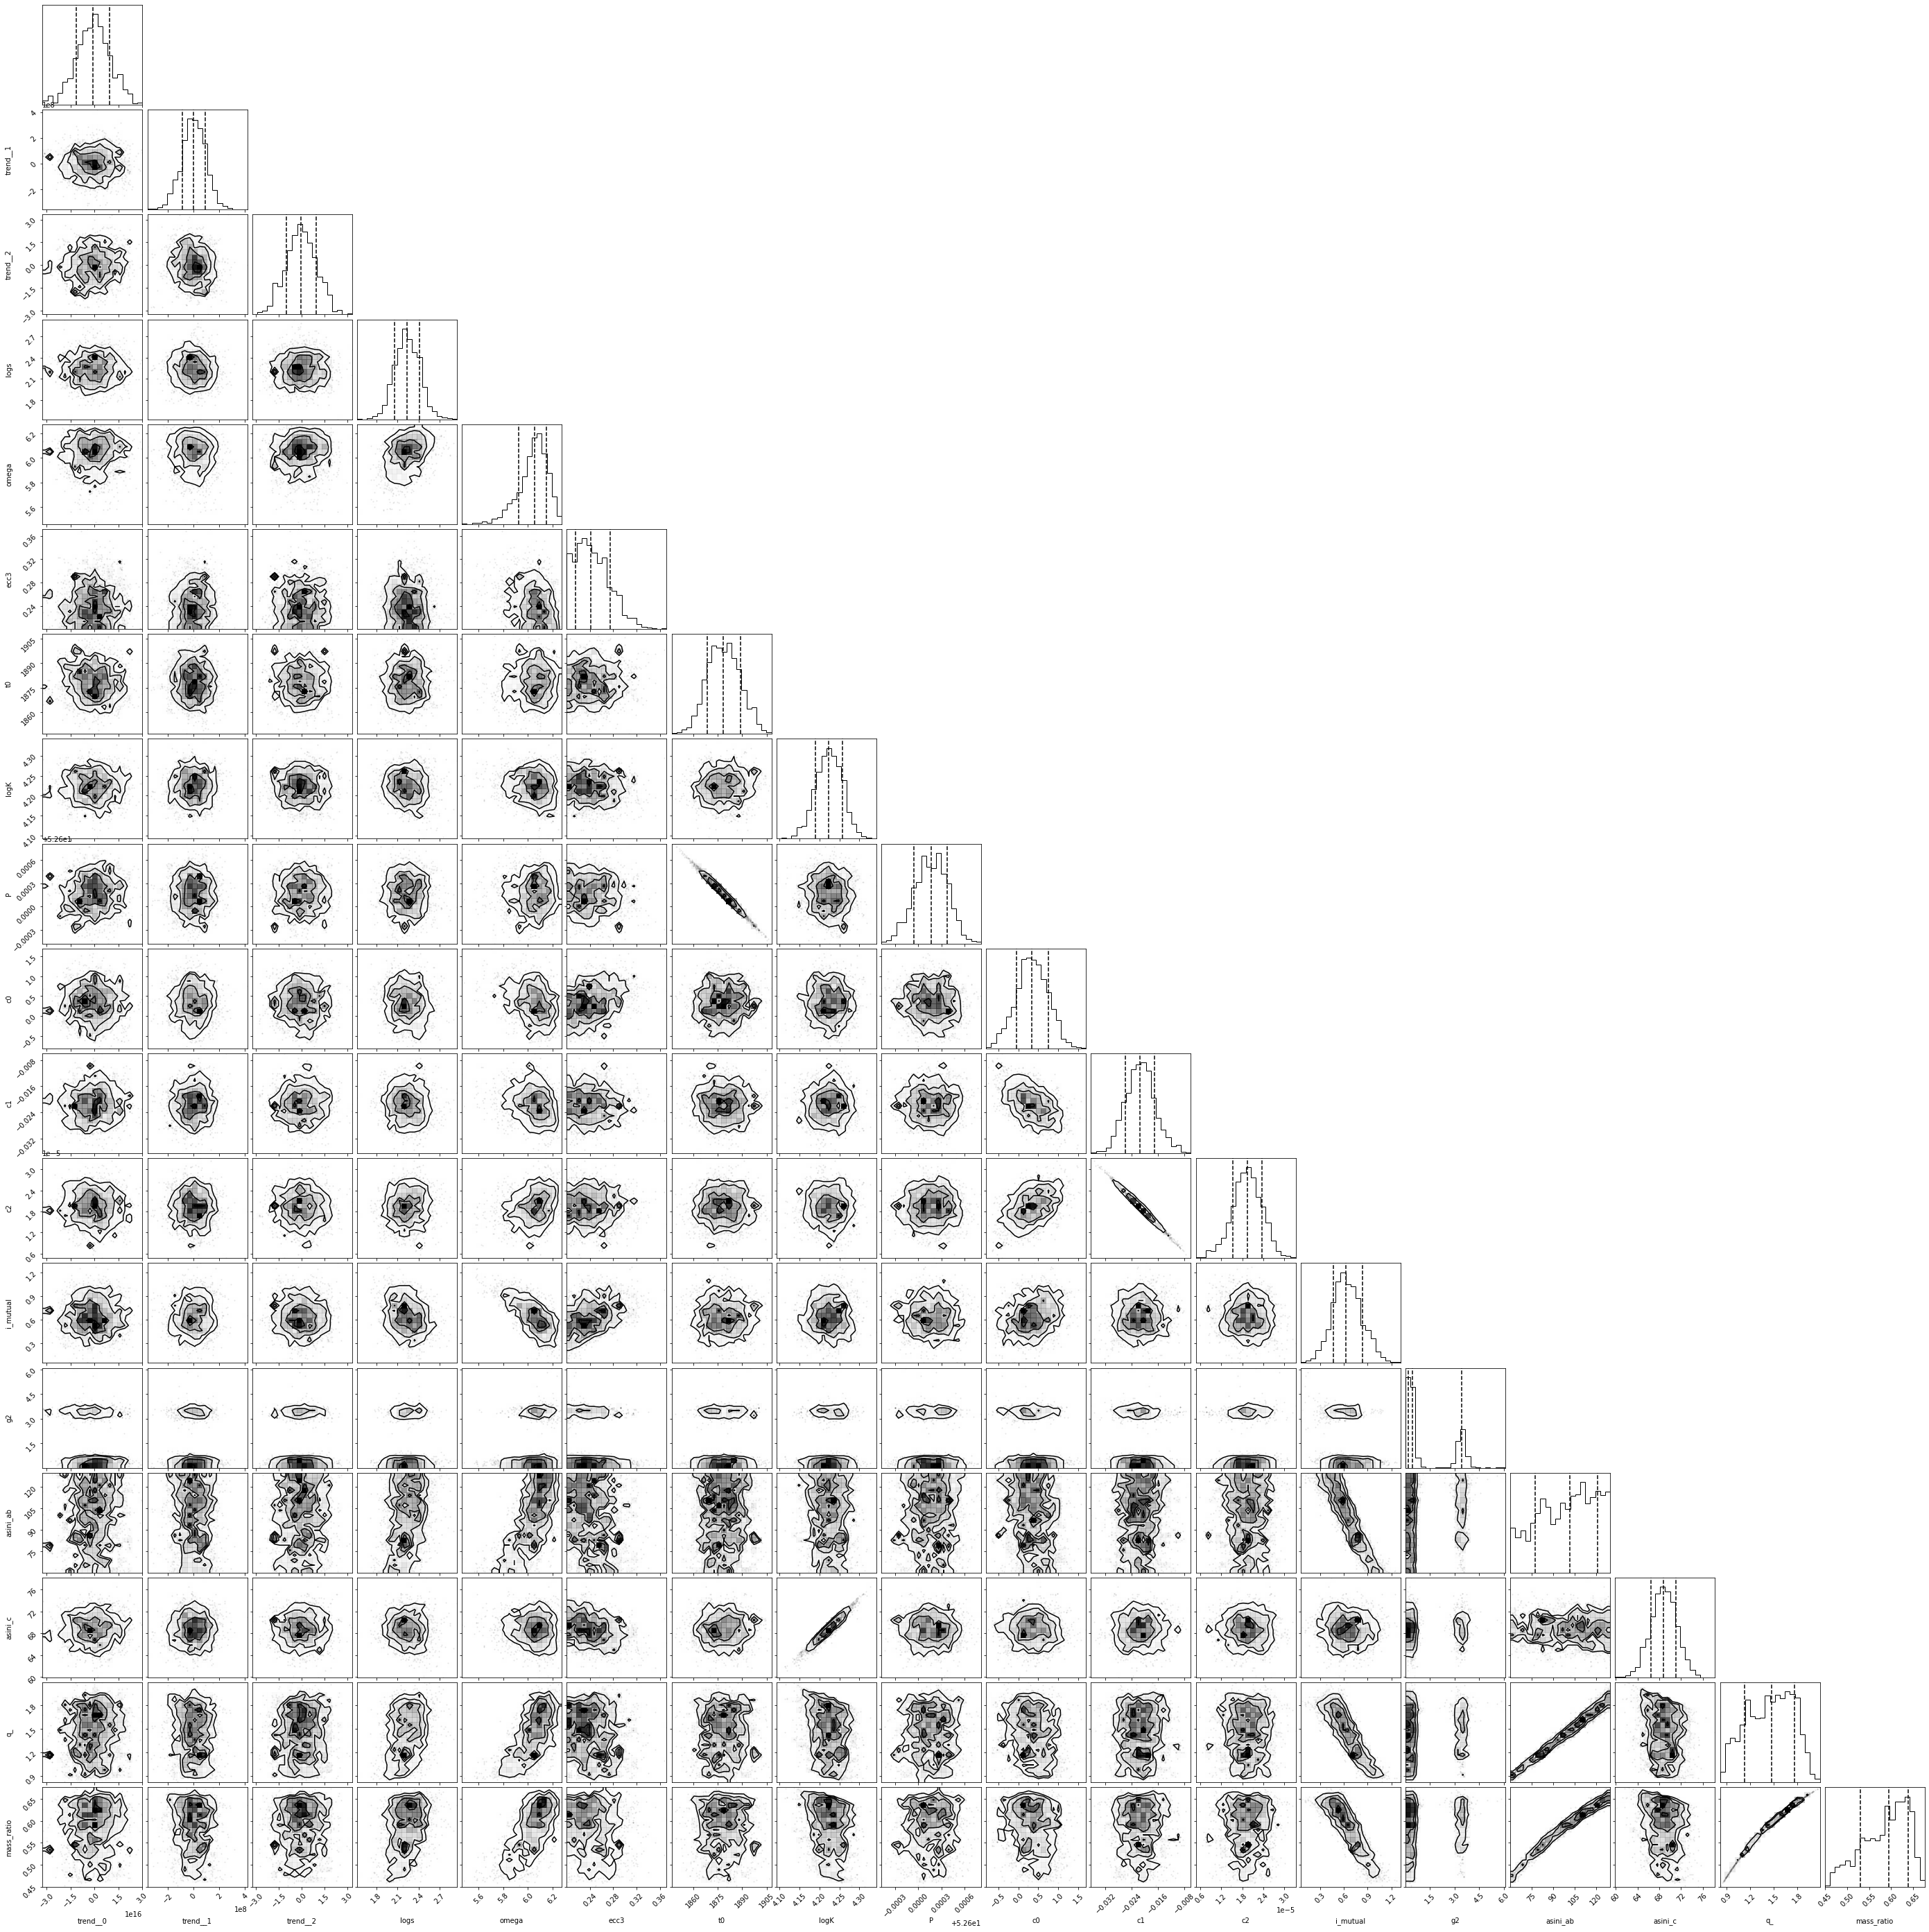

In [24]:

samples = pm.trace_to_dataframe(trace2, varnames=["trend", "logs", "omega", "ecc3", "t0", "logK", "P", "c0", "c1", "c2", "i_mutual", "g2", "asini_ab", "asini_c", "q_","mass_ratio"])

_ = corner.corner(samples, quantiles=[0.16, 0.5, 0.84])

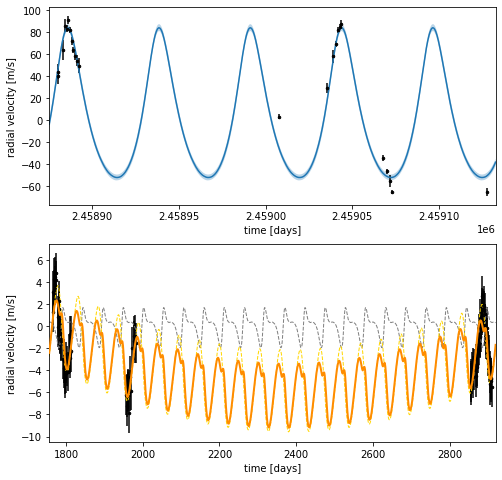

In [25]:
fig, ax = plt.subplots(2,1, figsize=(8,8))

ax[0].errorbar(x, y, yerr=yerr, fmt=".k")

# Compute the posterior predictions for the RV model
pred = np.percentile(trace2["rv_model_pred"], [16, 50, 84], axis=0)
ax[0].plot(t, pred[1], color="C0", label="model")
art = ax[0].fill_between(t, pred[0], pred[2], color="C0", alpha=0.3)
art.set_edgecolor("none")

#ax[0].legend(fontsize=10)
ax[0].set_xlim(t.min(), t.max())
ax[0].set_xlabel("time [days]")
ax[0].set_ylabel("radial velocity [m/s]")
#_ = ax[0].set_title("posterior constraints")


# Compute the posterior predictions for the RV model
ax[1].errorbar(x_etv, y_etv, yerr=yerr_etv, fmt=".k")

pred = np.percentile(trace2["etv_model_pred"], [16, 50, 84], axis=0)
ax[1].plot(x_etv_array, pred[1], color="darkorange", label="model", lw = 2, zorder = 10)
#art = ax[1].fill_between(x_etv_array, pred[0], pred[2], color="darkorange", alpha=0.3)
#art.set_edgecolor("none")

pred = np.percentile(trace2["delta_dyn_pred"], [16, 50, 84], axis=0)
ax[1].plot(x_etv_array, pred[1], color="grey", label="model", ls = '--', lw = 1)
#art = ax[1].fill_between(x_etv_array, pred[0], pred[2], color="grey", alpha=0.3)
#art.set_edgecolor("none")

pred = np.percentile(trace2["delta_ltte_pred"], [16, 50, 84], axis=0)
ax[1].plot(x_etv_array, pred[1], color="gold", label="model", ls = '--', lw = 1)
#art = ax[1].fill_between(x_etv_array, pred[0], pred[2], color="gold", alpha=0.3)
#art.set_edgecolor("none")

#ax[1].axhline(0)
#delta_dyn
#delta_ltte
#ax[1].legend(fontsize=10)

ax[1].set_xlim(x_etv_array.min(), x_etv_array.max())
ax[1].set_xlabel("time [days]")
ax[1].set_ylabel("radial velocity [m/s]")
#_ = ax[1].set_title("posterior constraints")

plt.show()


[[-1.87552522e+20 -1.86802313e+20 -1.86053607e+20 ... -1.86053607e+20
  -1.86802313e+20 -1.87552522e+20]
 [-1.19838059e+19 -1.19358707e+19 -1.18880316e+19 ... -1.18880316e+19
  -1.19358707e+19 -1.19838059e+19]
 [ 1.59699300e+20  1.59060504e+20  1.58422987e+20 ...  1.58422987e+20
   1.59060504e+20  1.59699300e+20]]


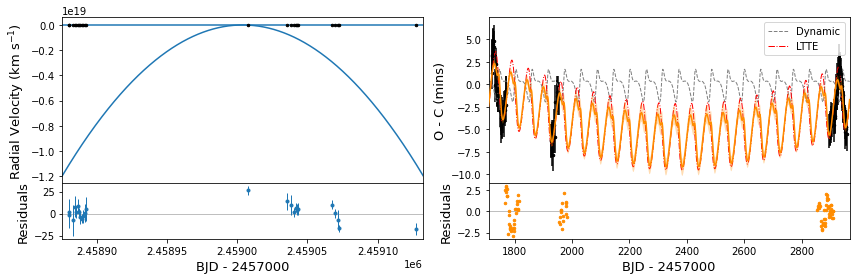

In [26]:
from matplotlib import gridspec

# plot it
fig = plt.figure(figsize=(12, 4)) 

gs = gridspec.GridSpec(2, 2, height_ratios=[3, 1], hspace = 0) 
ax0 = plt.subplot(gs[0])

ax0.errorbar(x, y, yerr=yerr, fmt=".k")

# Compute the posterior predictions for the RV model

pred_bkg = np.percentile(trace2["bkg_pred"], [16, 50, 84], axis=0)
ax0.plot(t, pred_bkg[1]*1, color="C0", label="model")
print (pred_bkg)


pred = np.percentile(trace2["rv_model_pred"], [16, 50, 84], axis=0)
ax0.plot(t, pred[1], color="C0", label="model")


art = ax0.fill_between(t, pred[0], pred[2], color="C0", alpha=0.3)
art.set_edgecolor("none")

#ax[0].legend(fontsize=10)
ax0.set_xlim(t.min(), t.max())
ax0.set_ylabel(r"Radial Velocity (km s$^{-1}$)", fontsize = 13)


ax1 = plt.subplot(gs[2])
ax1.errorbar(x,y - (trace2["rv_model"][1]), yerr=yerr*2, lw = 0, marker = 'o', color="C0", ms = 3, elinewidth = 1,label="model")

ax1.axhline(0, color = 'grey', zorder = -1, lw = 1, alpha = 0.5)
ax1.set_xlabel("BJD - 2457000", fontsize = 13)
ax1.set_ylabel("Residuals", fontsize = 13)
ax1.set_xlim(t.min(), t.max())

ax2 = plt.subplot(gs[1])

ax2.errorbar(x_etv, y_etv, yerr=yerr_etv, fmt=".k")
pred = np.percentile(trace2["etv_model_pred"], [16, 50, 84], axis=0)
ax2.plot(x_etv_array, pred[1], color="darkorange", zorder = 10) #, label="ETV model", 
art = ax2.fill_between(x_etv_array, pred[0], pred[2], color="darkorange", alpha=0.3, zorder = 10)
art.set_edgecolor("none")

pred = np.percentile(trace2["delta_dyn_pred"], [16, 50, 84], axis=0)
ax2.plot(x_etv_array, pred[1], color="grey", label="Dynamic", ls = '--', lw = 1)
#art = ax[1].fill_between(x_etv_array, pred[0], pred[2], color="grey", alpha=0.3)
#art.set_edgecolor("none")

pred = np.percentile(trace2["delta_ltte_pred"], [16, 50, 84], axis=0)
ax2.plot(x_etv_array, pred[1], color="red", label="LTTE", ls = '-.', lw = 1)


#ax[1].legend(fontsize=10)
ax2.set_xlim(x_etv_array.min(), x_etv_array.max())
ax2.legend()
ax2.set_ylabel("O - C (mins)", fontsize = 13)


ax3 = plt.subplot(gs[3])
ax3.plot(x_etv,y_etv - trace2["etv_model"][1], '.k', color="darkorange", label="model")
ax3.axhline(0, color = 'grey', zorder = -1, lw = 1, alpha = 0.5)
ax3.set_xlabel("BJD - 2457000", fontsize = 13)
ax3.set_ylabel("Residuals", fontsize = 13)
plt.tight_layout()

#plt.savefig('/Users/Nora/Documents/research/projects/fluffy/figs/470710327_ETV_rvs_2.png', dpi = 300)


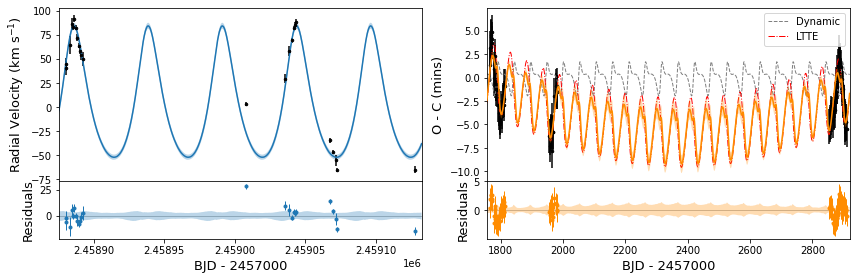

In [27]:
# plot it
fig = plt.figure(figsize=(12, 4)) 

gs = gridspec.GridSpec(2, 2, height_ratios=[3, 1], hspace = 0) 
ax0 = plt.subplot(gs[0])

ax0.errorbar(x, y, yerr=rv_error, fmt=".k")

# Compute the posterior predictions for the RV model

pred = np.percentile(trace2["rv_model_pred"], [16, 50, 84], axis=0)
pred_points = np.percentile(trace2["rv_model"], [16, 50, 84], axis=0)
pred_bkg = np.percentile(trace2["bkg_pred"], [16, 50, 84], axis=0)
pred_bkg_points = np.percentile(trace2["bkg"], [16, 50, 84], axis=0)

#ax0.plot(t, pred_bkg[1], color="grey", label="model")

bbkkgg = pred_bkg[1]*0
bbkkgg_points = pred_bkg_points[1]*0

ax0.plot(t, pred[1] + bbkkgg, color="C0", label="model")

art = ax0.fill_between(t, pred[0] + bbkkgg, pred[2] + bbkkgg, color="C0", alpha=0.3)
art.set_edgecolor("none")

#ax[0].legend(fontsize=10)
ax0.set_xlim(t.min(), t.max())
ax0.set_ylabel(r"Radial Velocity (km s$^{-1}$)", fontsize = 13)


ax1 = plt.subplot(gs[2])
ax1.errorbar(x,y - (pred_points[1] + bbkkgg_points), yerr=rv_error, lw = 0, marker = 'o', color="C0", ms = 3, elinewidth = 1,label="model")

ax1.axhline(0, color = 'grey', zorder = -1, lw = 1, alpha = 0.5)
ax1.set_xlabel("BJD - 2457000", fontsize = 13)
ax1.set_ylabel("Residuals", fontsize = 13)
ax1.set_xlim(t.min(), t.max())

art2 = ax1.fill_between(t, pred[0] - pred[1], pred[2] - pred[1], color="C0", alpha=0.3)
art2.set_edgecolor("none")


ax2 = plt.subplot(gs[1])


ax2.errorbar(x_etv, y_etv, yerr=yerr_etv, fmt=".k")
pred_etv = np.percentile(trace2["etv_model_pred"], [16, 50, 84], axis=0)
pred_etv_points = np.percentile(trace2["etv_model"], [16, 50, 84], axis=0)

ax2.plot(x_etv_array, pred_etv[1], color="darkorange", zorder = 10) #, label="ETV model", 
art = ax2.fill_between(x_etv_array, pred_etv[0], pred_etv[2], color="darkorange", alpha=0.3, zorder = 10)
art.set_edgecolor("none")


# -----

pred = np.percentile(trace2["delta_dyn_pred"], [16, 50, 84], axis=0)
ax2.plot(x_etv_array, pred[1], color="grey", label="Dynamic", ls = '--', lw = 1)
#art = ax[1].fill_between(x_etv_array, pred[0], pred[2], color="grey", alpha=0.3)
#art.set_edgecolor("none")

pred = np.percentile(trace2["delta_ltte_pred"], [16, 50, 84], axis=0)

ax2.plot(x_etv_array, pred[1], color="red", label="LTTE", ls = '-.', lw = 1)


#ax[1].legend(fontsize=10)
ax2.set_xlim(x_etv_array.min(), x_etv_array.max())
ax2.legend()
ax2.set_ylabel("O - C (mins)", fontsize = 13)


ax3 = plt.subplot(gs[3])
ax3.errorbar(x_etv, y_etv - pred_etv_points[1], yerr=yerr_etv, lw = 0, marker = 'o', color="darkorange", ms = 3, elinewidth = 1,label="model")

#ax3.plot(x_etv,y_etv - trace2["etv_model"][1], '.k', color="darkorange", label="model")
ax3.axhline(0, color = 'grey', zorder = -1, lw = 1, alpha = 0.5)
ax3.set_xlabel("BJD - 2457000", fontsize = 13)
ax3.set_ylabel("Residuals", fontsize = 13)

art4 = ax3.fill_between(x_etv_array, pred_etv[0] - pred_etv[1], pred_etv[2] - pred_etv[1], color="darkorange", alpha=0.3)
art4.set_edgecolor("none")

ax2.set_xlim(x_etv_array.min(), x_etv_array.max())
ax3.set_xlim(x_etv_array.min(), x_etv_array.max())

plt.tight_layout()

#plt.savefig('/Users/Nora/Documents/research/projects/fluffy/figs/470710327_ETV_rvs_2.png', dpi = 300)


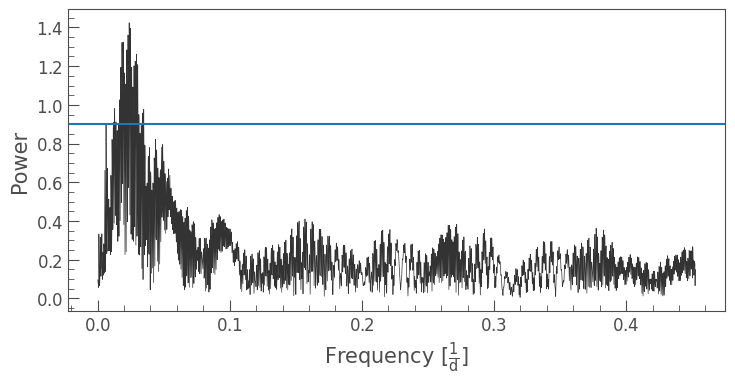

In [28]:
import lightkurve as lk

lc = lk.lightcurve.LightCurve(time = x_etv, flux = y_etv - trace2["etv_model"][1])

ls = lc.to_periodogram()

ax = ls.plot();
#k = ls.smooth(method='boxkernel', filter_width=25.)
#k.plot(scale = 'log', ax = ax, color = 'red', lw = 2)

ax.axhline(4.*np.mean(ls.power))
plt.show()


In [29]:
# calculate the BIC and AIC 


def aic(y, y_pred, p):
    
    n = len(y)
    
    # Calculation
    resid = np.subtract(y_pred, y)
    rss = np.sum(np.power(resid, 2))
    aic_score = n*np.log(rss/n) + 2*p
    
    return aic_score

def bic(y, y_pred, p):
    
    n = len(y)
    
    # Score
    
    residual = np.subtract(y_pred, y)
    SSE = np.sum(np.power(residual, 2))
    BIC = n*np.log(SSE/n) + p*np.log(n)
    
    return BIC

In [30]:
AIC_etv = aic(y_etv, trace["etv_model"][1], 16)
BIC_etv = bic(y_etv, trace["etv_model"][1], 16)

AIC_rv = aic(y, trace["rv_model"][1], 16)
BIC_rv = bic(y, trace["rv_model"][1], 16)

In [31]:
print("AIC_rv                       : {}".format(AIC_rv))
print("BIC_rv                       : {}".format(BIC_rv))
print ("stdv rv residuals            : {}".format(np.std(y - trace["rv_model"][1])))
print ()   
print("AIC_etv                      : {}".format(AIC_etv))
print("BIC_etv                      : {}".format(BIC_etv))
print ("stdv etv residuals           : {} ".format(np.std(y_etv - trace["etv_model"][1])))

print ()
print("AIC_total                    : {}".format(AIC_rv + AIC_etv))
print("BIC_total                    : {}".format(BIC_rv + BIC_etv))


AIC_rv                       : 140.16931749469154
BIC_rv                       : 159.01817878025867
stdv rv residuals            : 9.521105701265494

AIC_etv                      : 100.53669174906234
BIC_etv                      : 140.885308981847
stdv etv residuals           : 1.4509299094514687 

AIC_total                    : 240.7060092437539
BIC_total                    : 299.90348776210567
